# oceanarray demo - mooring-level processing

This notebook walks through the instrument-level processing.


In [1]:
from pathlib import Path
import numpy as np
import xarray as xr
import numpy as np
from oceanarray import readers, rodb, mooring, plotters, tools


# Mooring-level processing

## Step 1: Grid in time

In this case, we'll grid in time by first filtering the original data with a 2-day 6th order Butterworth lowpass filter, then grid to a 12 hour interval by linear interpolation.  


In [2]:
data_dir = Path(".." ,"data")
input_file_pre = 'wb2_9_201114*use'
input_files = list(data_dir.glob(input_file_pre))
ds_list = [rodb.rodbload(f) for f in input_files]

<xarray.Dataset> Size: 24kB
Dimensions:         (TIME: 609)
Coordinates:
  * TIME            (TIME) datetime64[ns] 5kB 2011-04-29 ... 2012-02-27
    N_MEASUREMENTS  (TIME) int64 5kB 8 32 56 80 104 ... 14528 14552 14576 14600
Data variables:
    T               (TIME) float64 5kB 3.764 3.769 3.789 ... 3.778 3.785 3.776
    C               (TIME) float64 5kB 33.09 33.1 33.12 ... 33.11 33.12 33.11
    P               (TIME) float64 5kB 1.79e+03 1.79e+03 ... 1.801e+03 1.801e+03
    InstrDepth      float64 8B 1.7e+03
    Latitude        float64 8B 26.52
    Longitude       float64 8B -76.74
Attributes:
    mooring:        wb2_9_201114
    serial_number:  6823
    water_depth:    3880
    start_time:     2011/04/28T20:00
    end_time:       2012/02/27T19:00
    source_file:    ../data/wb2_9_201114_6823.use
    columns:        ['YY', 'MM', 'DD', 'HH', 'T', 'C', 'P']

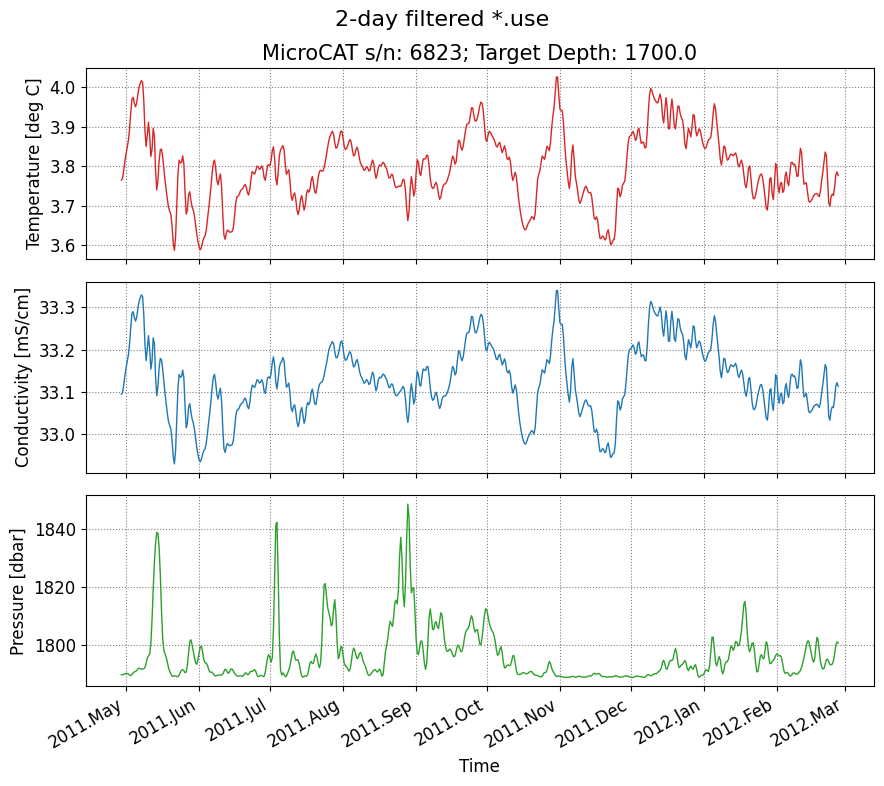

In [3]:
# Extract one dataset for demonstration of filtering
ds1 = ds_list[0]
ds_filt = mooring.filter_all_time_vars(ds1)
ds_interp = mooring.interp_to_12hour_grid(ds_filt)
fig = plotters.plot_microcat(ds_interp)
fig.suptitle("2-day filtered *.use", fontsize=16, y=0.98)

ds_interp

In [ ]:
# Apply filter to all datasets
ds_li = []
for ds in ds_list:
    ds_filt = mooring.filter_all_time_vars(ds)
    ds_interp = mooring.interp_to_12hour_grid(ds_filt)
    ds_li.append(ds_interp)



## Step 2: Grid vertically

In [5]:
stacked_ds = mooring.stack_instruments(ds_li)
stacked_ds

<xarray.Dataset> Size: 258kB
Dimensions:         (N_LEVELS: 17, TIME: 609)
Coordinates:
  * TIME            (TIME) datetime64[ns] 5kB 2011-04-29 ... 2012-02-27
    N_MEASUREMENTS  (TIME) int64 5kB 8 32 56 80 104 ... 14528 14552 14576 14600
  * N_LEVELS        (N_LEVELS) int64 136B 0 1 2 3 4 5 6 ... 10 11 12 13 14 15 16
    InstrDepth      (N_LEVELS) float64 136B 50.0 100.0 ... 3.3e+03 3.85e+03
Data variables:
    C               (N_LEVELS, TIME) float64 83kB 52.61 52.75 ... 32.54 32.54
    P               (N_LEVELS, TIME) float64 83kB 65.99 63.23 ... 3.898e+03
    T               (N_LEVELS, TIME) float64 83kB 22.29 22.49 ... 2.303 2.303
Attributes:
    columns:         ['YY', 'MM', 'DD', 'HH', 'T', 'C', 'P']
    start_time:      2011/04/28T20:00
    water_depth:     3880
    end_time:        2012/02/27T19:00
    mooring:         wb2_9_201114
    Latitude:        26.515333333333334
    Longitude:       -76.74283333333334
    serial_numbers:  ['3220', '5242', '4619', '5765', '3903', '3904', '3910',...

In [ ]:
# Interpolate using the rapid_interp